Epoch [1/5], Loss: 2.2614
Epoch [2/5], Loss: 2.2593
Epoch [3/5], Loss: 2.2593
Epoch [4/5], Loss: 2.2586
Epoch [5/5], Loss: 2.2583
Trénování klasifikátoru s pseudo-labely dokončeno!


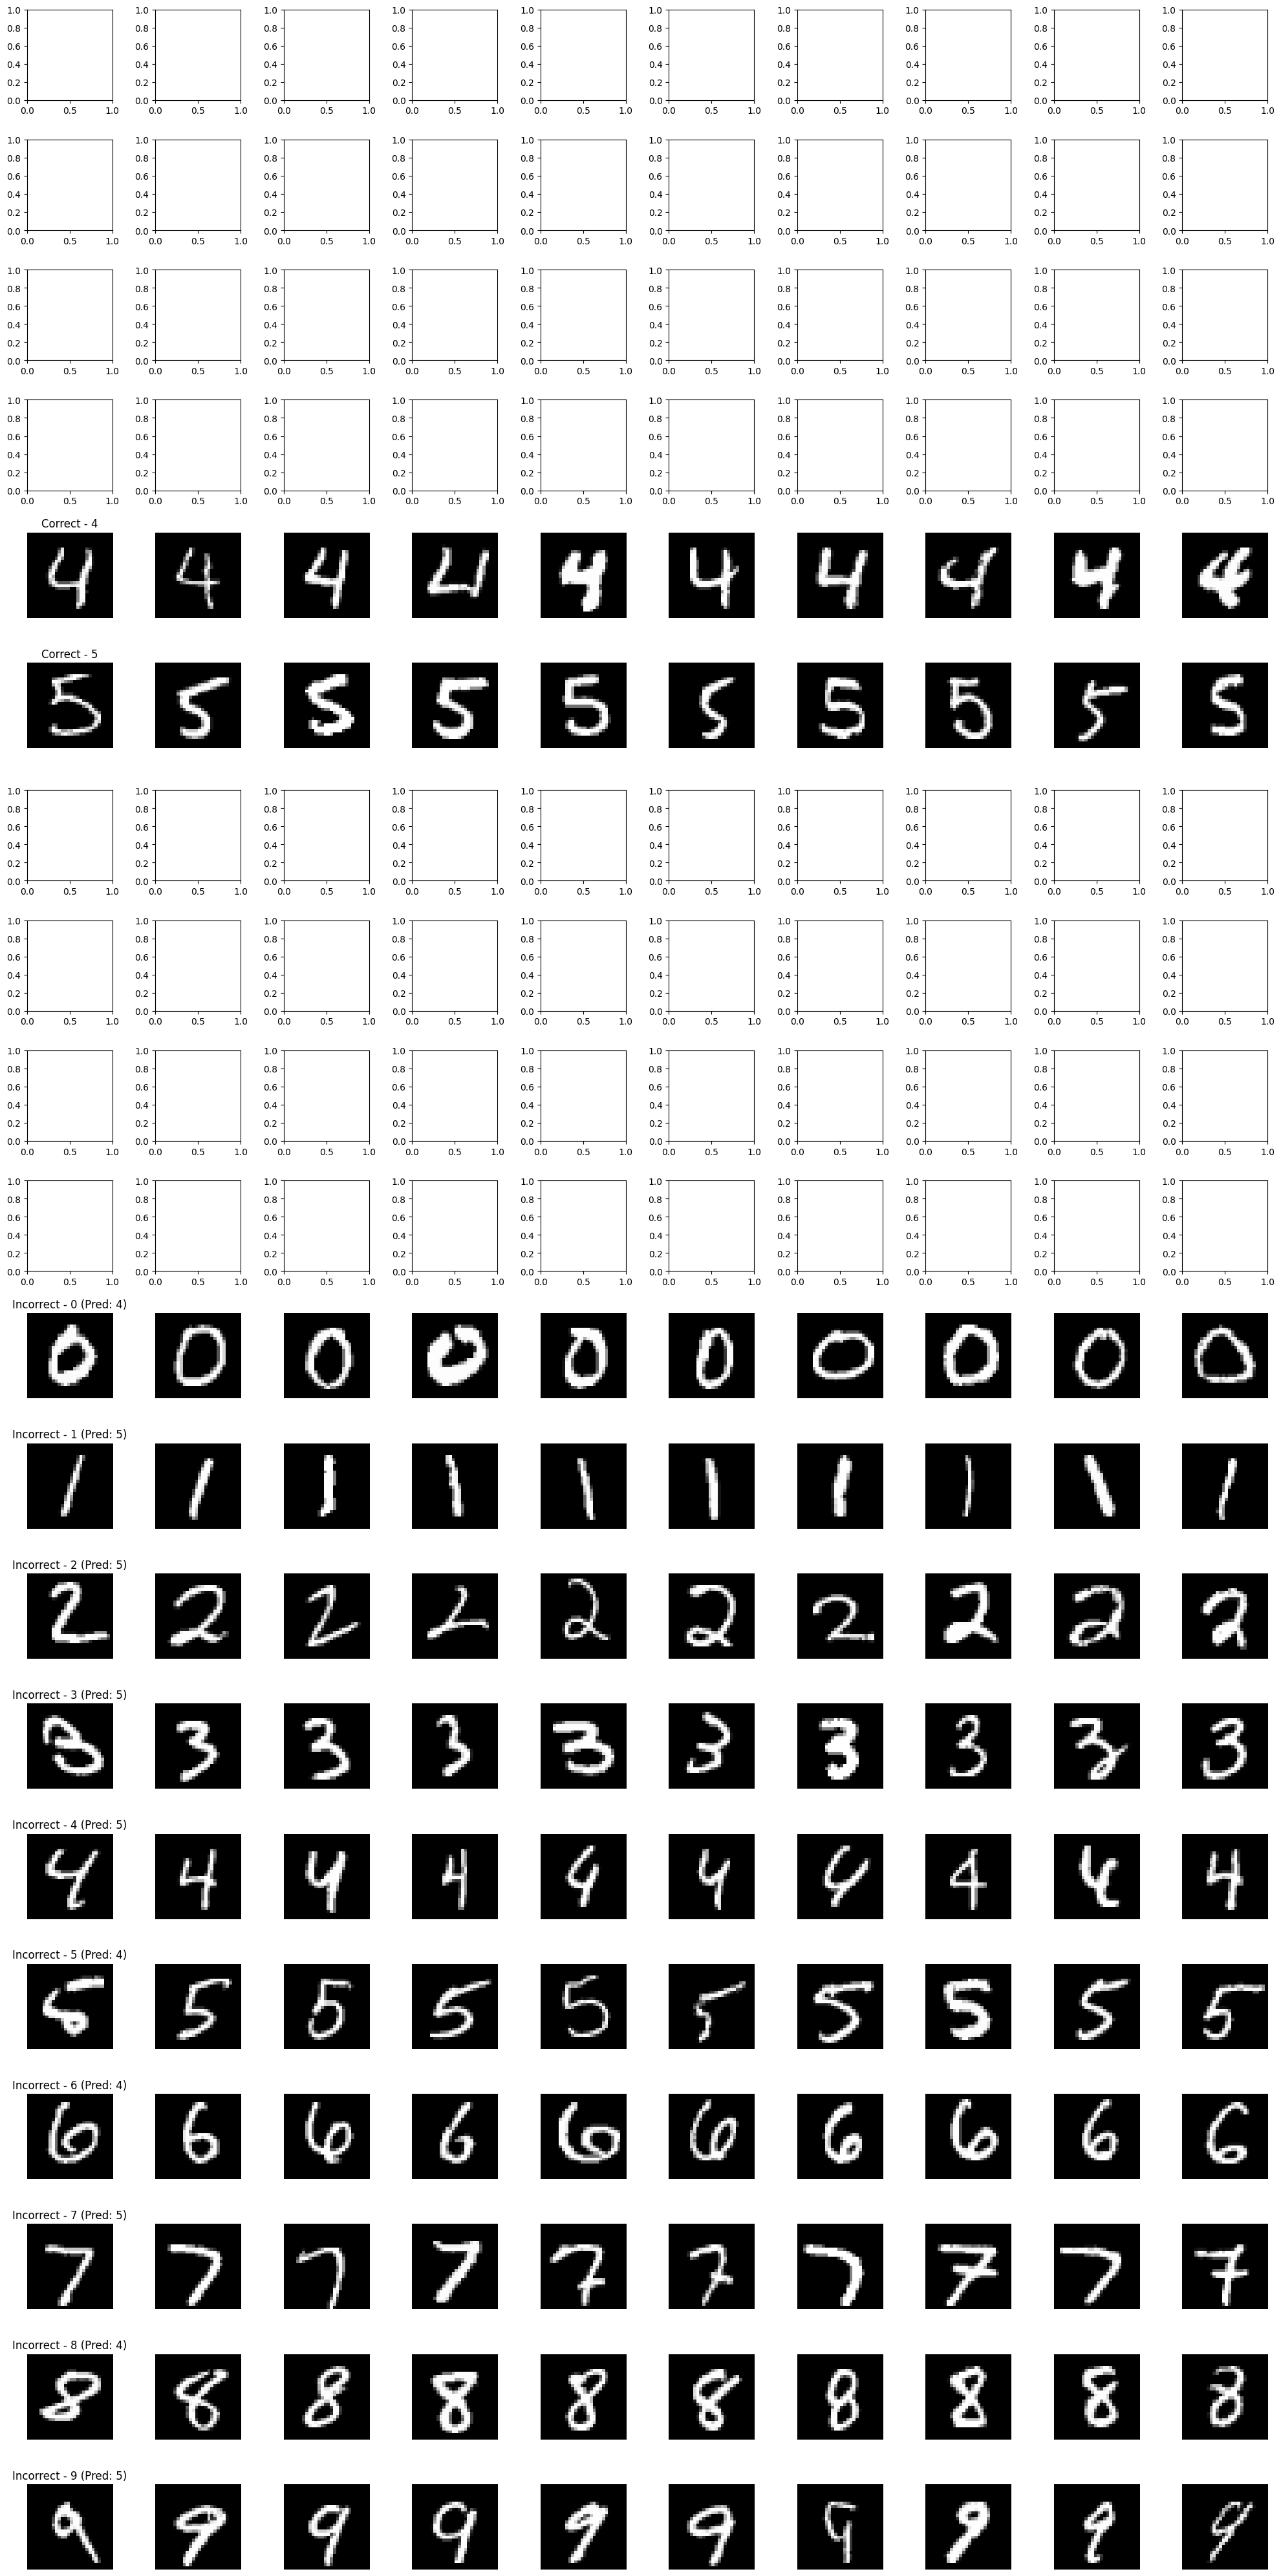

Test Accuracy: 8.60%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Definice jednoduché konvoluční sítě pro extrakci reprezentací
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.conv(x)

# Klasifikátor (použijeme po nalezení pseudo-labelů)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.features = FeatureExtractor()
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 tříd pro FashionMNIST
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Příprava datasetu a modelu
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Inicializace modelu pro extrakci reprezentací
feature_extractor = FeatureExtractor()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor.to(device)

# Extrahování latentních reprezentací pro celý dataset
def extract_features(dataloader, model):
    model.eval()  # Přepnutí do eval módu
    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Zploštění
            features.append(outputs.cpu())
    return torch.cat(features)

# Extrakce reprezentací z trénovacích dat
features = extract_features(train_loader, feature_extractor)

# Clustering (k-means) na extrahovaných reprezentacích
kmeans = KMeans(n_clusters=10, random_state=0).fit(features)

# Pseudo-labely získané z clusteringu
pseudo_labels = kmeans.labels_

# Vytvoření datasetu s pseudo-labely
class PseudoLabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, pseudo_labels):
        self.dataset = dataset
        self.pseudo_labels = pseudo_labels

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        pseudo_label = self.pseudo_labels[index]
        return img, pseudo_label

    def __len__(self):
        return len(self.dataset)

pseudo_labeled_dataset = PseudoLabeledDataset(train_dataset, pseudo_labels)
pseudo_loader = DataLoader(pseudo_labeled_dataset, batch_size=64, shuffle=True)

# Trénování klasifikátoru na pseudo-labely
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Trénování klasifikátoru na pseudo-labely
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in pseudo_loader:
        images = images.to(device)
        labels = labels.to(device).long()  # Přidána konverze pseudo-labelů na torch.LongTensor

        # Dopředný průchod
        outputs = classifier(images)
        loss = criterion(outputs, labels)

        # Zpětný průchod a optimalizace
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(pseudo_loader):.4f}')

print('Trénování klasifikátoru s pseudo-labely dokončeno!')


# ------------------------ ZOBRAZENÍ OBRÁZKŮ ZE SHLUKŮ ------------------------

def show_images_from_clusters(dataset, kmeans_labels, num_images=5):
    clusters = {i: [] for i in range(10)}  # Slovník pro uložení indexů obrázků v jednotlivých clusterech

    # Rozdělení indexů obrázků do jednotlivých shluků
    for idx, label in enumerate(kmeans_labels):
        clusters[label].append(idx)

    fig, axes = plt.subplots(10, num_images, figsize=(num_images * 2, 20))

    for cluster in range(10):
        # Vyber náhodně `num_images` indexů z každého shluku
        if len(clusters[cluster]) < num_images:
            print(f"Cluster {cluster} má méně než {num_images} obrázků, zobrazujeme všechny dostupné.")
            chosen_indices = clusters[cluster]  # Pokud máme méně obrázků, zobraz všechny
        else:
            chosen_indices = random.sample(clusters[cluster], num_images)  # Náhodný výběr obrázků

        for i, idx in enumerate(chosen_indices):
            image, _ = dataset[idx]  # Získání obrázku z datasetu
            axes[cluster, i].imshow(image.squeeze(), cmap='gray')
            axes[cluster, i].axis('off')
            if i == 0:
                axes[cluster, i].set_title(f'Cluster {cluster}', fontsize=12)

    plt.tight_layout()
    plt.show()


# ------------------------ TESTOVÁNÍ MODELŮ ------------------------

# Testovací data pro vyhodnocení klasifikace
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Funkce pro vyhodnocení přesnosti na testovacích datech
import matplotlib.pyplot as plt

def evaluate_model(dataloader, model, num_examples=10):
    model.eval()  # Přepnutí do eval módu (vypnutí dropout/batch norm)
    correct_per_class = {i: [] for i in range(10)}  # Slovník pro správně klasifikované obrázky
    incorrect_per_class = {i: [] for i in range(10)}  # Slovník pro špatně klasifikované obrázky

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            for i in range(len(predicted)):
                label = labels[i].item()
                if predicted[i] == labels[i]:
                    if len(correct_per_class[label]) < num_examples:  # Uložíme správně klasifikované obrázky
                        correct_per_class[label].append(images[i].cpu())
                else:
                    if len(incorrect_per_class[label]) < num_examples:  # Uložíme špatně klasifikované obrázky
                        incorrect_per_class[label].append((images[i].cpu(), predicted[i].item()))

            correct += (predicted == labels).sum().item()

            # Ukončíme smyčku, pokud máme dostatek obrázků pro každou třídu
            if all(len(correct_per_class[label]) >= num_examples and len(incorrect_per_class[label]) >= num_examples for label in range(10)):
                break

    accuracy = 100 * correct / total

    # Zobrazení obrázků
    show_images(correct_per_class, incorrect_per_class, num_examples)

    return accuracy

def show_images(correct_per_class, incorrect_per_class, num_examples=10):
    fig, axes = plt.subplots(20, num_examples, figsize=(num_examples * 2, 40))

    for label in range(10):
        # Zobrazení správně klasifikovaných obrázků
        for i in range(min(len(correct_per_class[label]), num_examples)):
            image = correct_per_class[label][i].squeeze()  # Správně klasifikované
            axes[label, i].imshow(image, cmap='gray')
            axes[label, i].axis('off')
            if i == 0:
                axes[label, i].set_title(f'Correct - {label}', fontsize=12)

        # Zobrazení špatně klasifikovaných obrázků
        for i in range(min(len(incorrect_per_class[label]), num_examples)):
            image, predicted = incorrect_per_class[label][i]  # Špatně klasifikované
            image = image.squeeze()
            axes[label + 10, i].imshow(image, cmap='gray')
            axes[label + 10, i].axis('off')
            if i == 0:
                axes[label + 10, i].set_title(f'Incorrect - {label} (Pred: {predicted})', fontsize=12)

    plt.tight_layout()
    plt.show()



# Vyhodnocení přesnosti na testovací sadě
test_accuracy = evaluate_model(test_loader, classifier)
print(f'Test Accuracy: {test_accuracy:.2f}%')


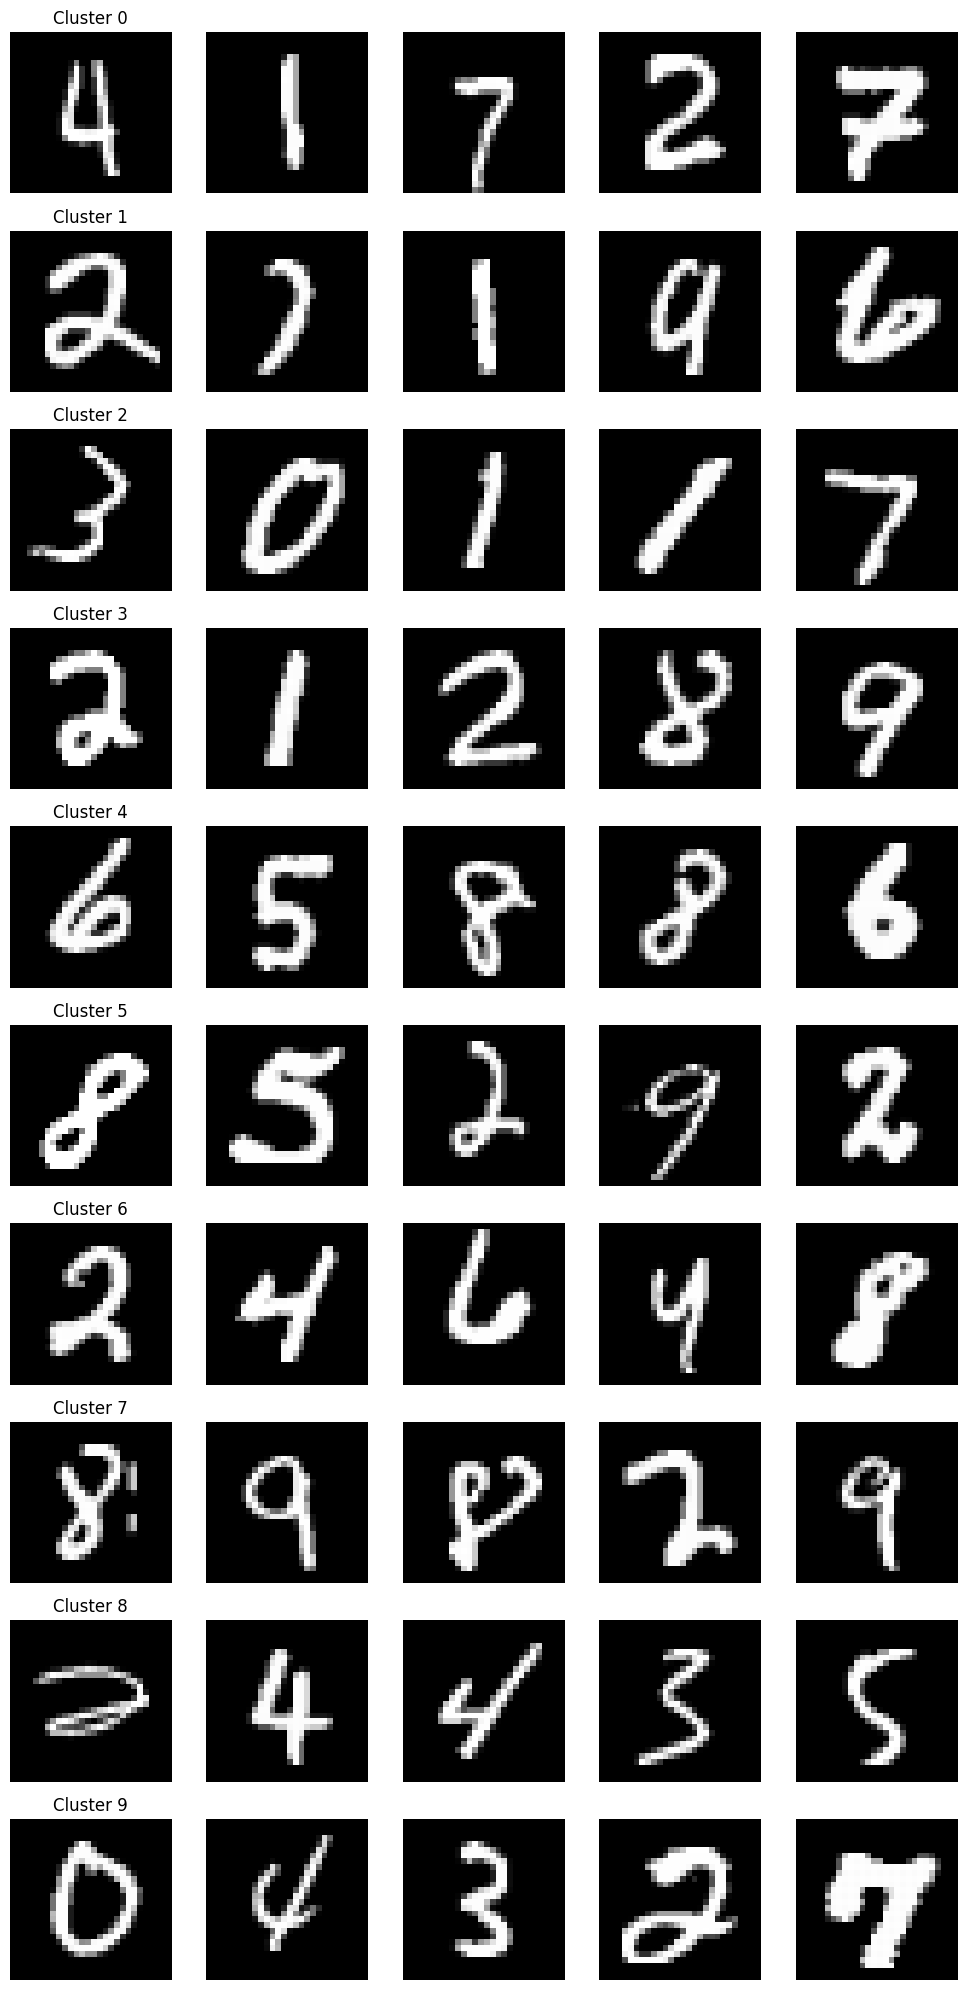

In [13]:
# Zobrazení 5 obrázků z každého shluku
show_images_from_clusters(train_dataset, pseudo_labels, num_images=5)